In [134]:
## Figure 9 - Filtering effect of network inversion on decorrelation noise
## comparison between observed interferometric phase and reconstructed phase from inverted time-series

import os
import numpy as np
import matplotlib.pyplot as plt
import pysar.plot_network as pnet
from pysar.simulation.plot import *
from pysar.objects import sensor, ifgramStack
from pysar.utils import readfile, plot as pp, utils as ut

work_dir = os.path.expanduser('~/insarlab/PYSAR_EXAMPLE/SierraNegraAlosAT133/PYSAR')
os.chdir(work_dir)
print('Go to diretory: '+work_dir)
proj_name = sensor.project_name2sensor_name(work_dir)[1]

ifgram_file = './INPUTS/ifgramStack.h5'
ts_file = 'timeseries.h5'
water_mask_file = 'waterMask.h5'
dem = readfile.read('./INPUTS/geometryRadar.h5', datasetName='height')[0]

date12 = '20070115_20110313'
m_date, s_date = date12.split('_')

obj = ifgramStack(ifgram_file)
obj.open()
range2phase = -4. * np.pi / float(obj.metadata['WAVELENGTH'])
ref_y, ref_x = obj.refY, obj.refX  #765, 579    

# read coherence
coh = readfile.read(ifgram_file, datasetName='coherence-{}'.format(date12))[0]
water_mask = readfile.read(water_mask_file)[0]
coh[water_mask==0] = 0.

# read interferometric phase
pha_orig = readfile.read(ifgram_file, datasetName='unwrapPhase-{}'.format(date12))[0]
pha_orig[pha_orig!=0] -= pha_orig[ref_y, ref_x]
pha_orig[pha_orig==0] = np.nan
pha_orig[water_mask==0] = np.nan
#pha_orig = ut.wrap(pha_orig)

# read reconstructed phase
pha_recon =  readfile.read(ts_file, datasetName=s_date)[0]
pha_recon -= readfile.read(ts_file, datasetName=m_date)[0]
pha_recon *= range2phase
pha_recon -= pha_recon[ref_y, ref_x]
pha_recon[pha_recon==0] = np.nan
pha_recon[water_mask==0] = np.nan
#pha_recon = ut.wrap(pha_recon)

pha_diff = pha_recon - pha_orig
print('Done.')

Go to diretory: /Users/yunjunz/insarlab/PYSAR_EXAMPLE/SierraNegraAlosAT133/PYSAR
open ifgramStack file: ifgramStack.h5
Done.


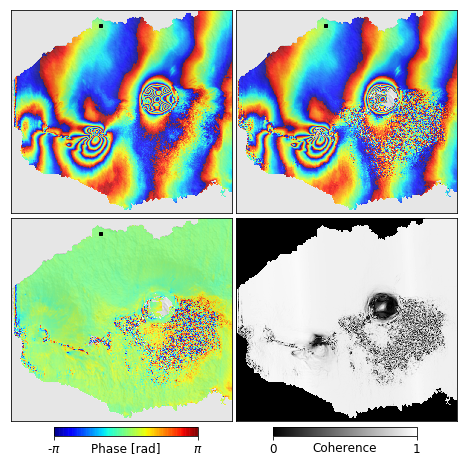

In [164]:
## Plot
inps = pp.cmd_line_parse()
inps.disp_dem_contour = False

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=[8, 8])
for i, (ax, pha) in enumerate(zip(axs.flatten(), np.array([pha_recon, pha_orig, pha_diff, coh]))):
    if i < 3:
        pp.plot_dem_background(ax=ax, geo_box=None, dem=dem, inps=inps, print_msg=False)
        im = ax.imshow(ut.wrap(pha), vmin=-np.pi, vmax=np.pi, cmap='jet', alpha=0.8)
        ax.plot(ref_x, ref_y, 'ks', ms=3)
    else:
        im2 = ax.imshow(coh, cmap='gray', vmin=0, vmax=1)
    # axis format
    pp.auto_flip_direction(obj.metadata, ax=ax, print_msg=False)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
plt.subplots_adjust(wspace=0.02, hspace=-0.08)

## colorbar
cax = fig.add_axes([0.2, 0.12, 0.25, 0.015])
cbar = plt.colorbar(im, cax=cax, ticks=[-1.*np.pi, np.pi], orientation='horizontal')
cbar.ax.set_xticklabels([r'-$\pi$', r'$\pi$'])
cbar.ax.tick_params(which='both', direction='out', labelsize=font_size)
cbar.set_label('Phase [rad]', fontsize=font_size, labelpad=-14)

cax2 = fig.add_axes([0.58, 0.12, 0.25, 0.015])
cbar2 = plt.colorbar(im2, cax=cax2, ticks=[0, 1], orientation='horizontal')
cbar2.ax.set_xticklabels(['0', '1'])
cbar2.ax.tick_params(which='both', direction='out', labelsize=font_size)
cbar2.set_label('Coherence', fontsize=font_size, labelpad=-14)

plt.savefig('{}_netInv_filter.png'.format(proj_name), bbox_inches='tight', transparent=True, dpi=fig_dpi)
plt.show()

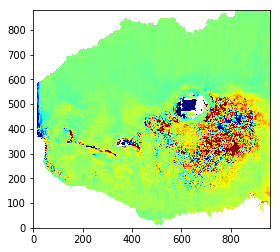

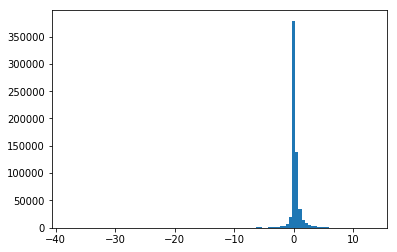

In [165]:
fig, ax = plt.subplots()
ax.imshow(pha_diff, cmap='jet', vmin=-np.pi, vmax=np.pi)
pp.auto_flip_direction(obj.metadata, ax=ax, print_msg=False)

plt.figure()
plt.hist(pha_diff[~np.isnan(pha_diff)].flatten(), bins=100)
plt.show()